<a href="https://colab.research.google.com/github/denpetrov/convolutional_neural_networks_tensorflow/blob/master/Exercise_5_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os, signal
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [0]:
# This code block downloads the full Cats-v-Dogs dataset and stores it as 
# cats-and-dogs.zip. It then unzips it to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# If the URL doesn't work, 
# .   visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2019-06-24 19:25:07--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.124.8.170, 2600:1407:2800:6a3::e59, 2600:1407:2800:683::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.124.8.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   212MB/s    in 3.8s    

2019-06-24 19:25:11 (209 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

12501
12501


In [0]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'

import shutil

def create_dir(dir_name):
  try:
    shutil.rmtree(dir_name)
  except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
  
  try:
    os.mkdir(dir_name)
  except OSError:
    pass

create_dir('/tmp/cats-v-dogs')
create_dir('/tmp/cats-v-dogs/training')
create_dir('/tmp/cats-v-dogs/testing')
create_dir('/tmp/cats-v-dogs/training/cats')
create_dir('/tmp/cats-v-dogs/training/dogs')
create_dir('/tmp/cats-v-dogs/testing/cats')
create_dir('/tmp/cats-v-dogs/testing/dogs')

Error: /tmp/cats-v-dogs/training - No such file or directory.
Error: /tmp/cats-v-dogs/testing - No such file or directory.
Error: /tmp/cats-v-dogs/training/cats - No such file or directory.
Error: /tmp/cats-v-dogs/training/dogs - No such file or directory.
Error: /tmp/cats-v-dogs/testing/cats - No such file or directory.
Error: /tmp/cats-v-dogs/testing/dogs - No such file or directory.


In [0]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  # YOUR CODE STARTS HERE
  # Check the size of images
  list_files = os.listdir(SOURCE)
  list_files_to_copy = list()

  for f_name in list_files:
    f = SOURCE + f_name
    if os.path.getsize(f) > 0:
      list_files_to_copy.append(f_name)
    else:
      print(f_name, 'is zero length, so ignoring')
  
  n_files = len(list_files_to_copy)
  list_files_to_copy = random.sample(list_files_to_copy, n_files)
  
  training_set_size = int(round(n_files * SPLIT_SIZE, 0))
  test_set_size = n_files - training_set_size

  # Split the files
  print(training_set_size, '(of ', n_files, ') -- trainin set.')
  print(len(list_files_to_copy[:training_set_size]))
  
  print(test_set_size, '(of ', n_files, ') -- test set.')
  print(len(list_files_to_copy[training_set_size:]))
  
  n = 0
  for f_name in list_files_to_copy[:training_set_size]:
    source = SOURCE + f_name
    destination = TRAINING + f_name
    copyfile(source, destination)
    n += 1
  
  print('n = ', n)
  
  n = 0
  for f_name in list_files_to_copy[training_set_size:]:
    source = SOURCE + f_name
    destination = TESTING + f_name
    copyfile(source, destination)
    n += 1
  
  print('n = ', n)
  
  # YOUR CODE ENDS HERE


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring
11250 (of  12500 ) -- trainin set.
11250
1250 (of  12500 ) -- test set.
1250
n =  11250
n =  1250
11702.jpg is zero length, so ignoring
11250 (of  12500 ) -- trainin set.
11250
1250 (of  12500 ) -- test set.
1250
n =  11250
n =  1250


In [0]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


In [0]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  

])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

W0624 19:25:27.360547 139726131898240 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0624 19:25:27.517489 139726131898240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [0]:
base_dir = os.path.join('/tmp', 'cats-v-dogs')

TRAINING_DIR = os.path.join(base_dir, 'training')  # YOUR CODE HERE

print(TRAINING_DIR, os.path.isdir(TRAINING_DIR))

train_datagen = ImageDataGenerator(rescale = 1.0/255.)  # YOUR CODE HERE
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))  # YOUR CODE HERE

VALIDATION_DIR = os.path.join(base_dir, 'testing')  # YOUR CODE HERE
validation_datagen = ImageDataGenerator(rescale = 1.0/255.)  #YOUR CODE HERE
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=20,
                                                              class_mode  = 'binary',
                                                              target_size = (150, 150))  # YOUR CODE HERE



# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

/tmp/cats-v-dogs/training True
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [15]:
history = model.fit_generator(train_generator,
                              epochs=50,
                              verbose=1,
                              validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/50
 386/1125 [=========>....................] - ETA: 51s - loss: 0.6954 - acc: 0.6202

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262146 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 262151 bytes but only got 0. Skipping tag 56
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 0. 
  warnings.warn(str(msg))


 620/1125 [===============>..............] - ETA: 34s - loss: 0.6438 - acc: 0.6549

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307363840 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 307888128 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting t

 878/1125 [======================>.......] - ETA: 16s - loss: 0.6100 - acc: 0.6792

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 209715200 bytes but only got 0. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 52428800 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 7027. Skipping tag 48
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

1118/1125 [============================>.] - ETA: 0s - loss: 0.5887 - acc: 0.6933

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6553600 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1050744 bytes but only got 4951. Skipping tag 51
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293339136 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 293863424 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expect

1124/1125 [============================>.] - ETA: 0s - loss: 0.5883 - acc: 0.6938

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404094976 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 404619264 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 425459712 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385474 bytes but only got 6833. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expe

1125/1125 [==============================] - 81s 72ms/step - loss: 0.5883 - acc: 0.6939 - val_loss: 0.4797 - val_acc: 0.7696
Epoch 2/50
1125/1125 [==============================] - 76s 67ms/step - loss: 0.4519 - acc: 0.7919 - val_loss: 0.4479 - val_acc: 0.7868
Epoch 3/50
1125/1125 [==============================] - 75s 67ms/step - loss: 0.3947 - acc: 0.8253 - val_loss: 0.3930 - val_acc: 0.8168
Epoch 4/50
1125/1125 [==============================] - 75s 66ms/step - loss: 0.3558 - acc: 0.8512 - val_loss: 0.4227 - val_acc: 0.8116
Epoch 5/50
1125/1125 [==============================] - 75s 67ms/step - loss: 0.3224 - acc: 0.8665 - val_loss: 0.4141 - val_acc: 0.8160
Epoch 6/50
1125/1125 [==============================] - 74s 66ms/step - loss: 0.2954 - acc: 0.8818 - val_loss: 0.4524 - val_acc: 0.8316
Epoch 7/50
1125/1125 [==============================] - 74s 66ms/step - loss: 0.2745 - acc: 0.8927 - val_loss: 0.8547 - val_acc: 0.7652
Epoch 8/50
1125/1125 [==============================] - 73s

Text(0.5, 1.0, 'Training and validation loss')

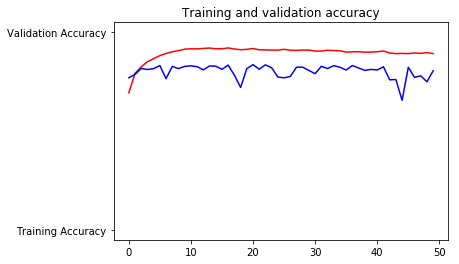

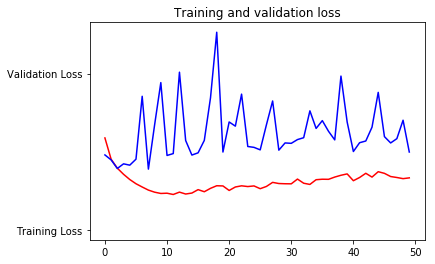

In [16]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [18]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0] > 0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving cat -baskakov-1318019-unsplash.jpg to cat -baskakov-1318019-unsplash (1).jpg
[0.]
cat -baskakov-1318019-unsplash.jpg is a cat


In [0]:
os.kill(     os.getpid() , 
         signal.SIGKILL
       )